In [1]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
!pwd

/users/avanti/interpret-benchmark/data


In [3]:
%matplotlib inline

import keras
from keras.models import model_from_json
from keras.models import Model
import h5py
import numpy as np
from deeplift import dinuc_shuffle
from matplotlib import pyplot as plt
import sys
from deeplift.visualization import viz_sequence
import scipy
from scipy import stats


argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    wilcoxon_result = scipy.stats.wilcoxon(differences)
    if (wilcoxon_result.pvalue > 0.05):
        symbol = "~"
    else:
        symbol = ">"
    
    if (negative_ranks < positive_ranks):
        print(method_2_name," "+symbol+" ",method_1_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
        plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
                 [np.min(method_1_scores), np.max(method_1_scores)],
                 color="black")
        plt.xlabel(method_1_name)
        plt.ylabel(method_2_name)     
    else:
        print(method_1_name," "+symbol+" ",method_2_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_2_scores, method_1_scores, alpha=0.3)
        plt.plot([np.min(method_2_scores), np.max(method_2_scores)],
                 [np.min(method_2_scores), np.max(method_2_scores)],
                 color="black")
        plt.xlabel(method_2_name)
        plt.ylabel(method_1_name)
    plt.show()
    

Using TensorFlow backend.


In [4]:
folder="HepG2"
model_prefix="record_1_model_txak1"

model_weights = folder+"/model_files/"+model_prefix+"_modelWeights.h5"
model_json = folder+"/model_files/"+model_prefix+"_modelJson.json"

In [5]:
keras_model = model_from_json(open(model_json).read())
keras_model.load_weights(model_weights)

preact_model = Model(inputs=keras_model.input,
                     outputs=keras_model.layers[-2].output)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [6]:
imp_scores_fh = h5py.File(folder+"/imp_scores_"+model_prefix+".h5", "r")
onehot_seq = np.array(imp_scores_fh['onehot'])
orig_preds = preact_model.predict(onehot_seq).squeeze()

seqs = [onehot_to_seq(x) for x in onehot_seq]

import random
np.random.seed(1234)
random.seed(1234)

shuffled_onehot_seqs = np.array([one_hot_encode_along_channel_axis(dinuc_shuffle.dinuc_shuffle(x)) for x in seqs])
shuffled_preds = preact_model.predict(shuffled_onehot_seqs).squeeze()

In [7]:
alphas = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
interp_inputs = [onehot_seq*(alpha) + shuffled_onehot_seqs*(1-alpha)
                 for alpha in alphas]
interp_preds = [preact_model.predict(x).squeeze()
                for x in interp_inputs]

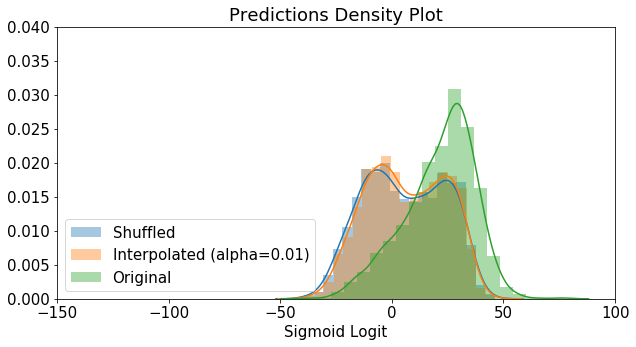

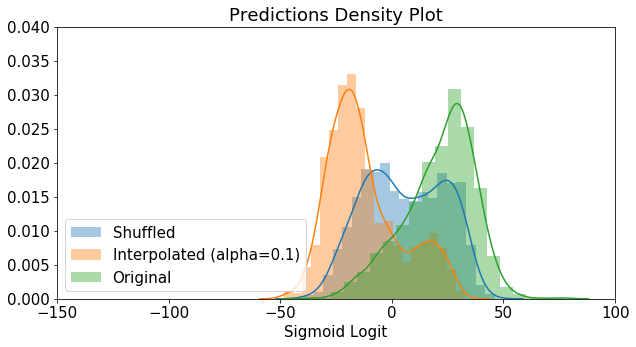

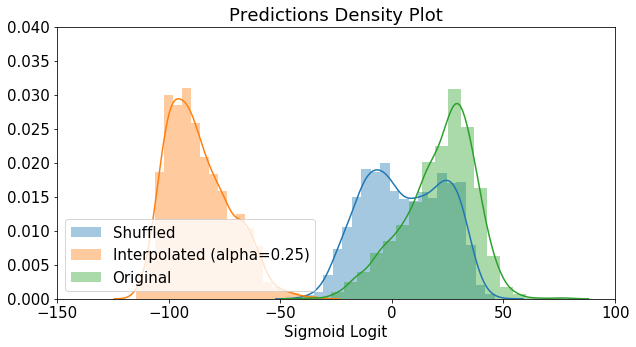

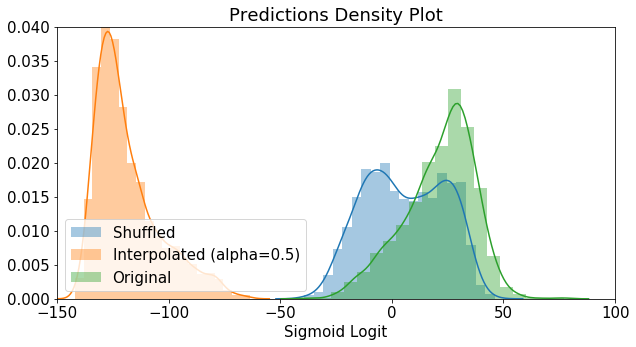

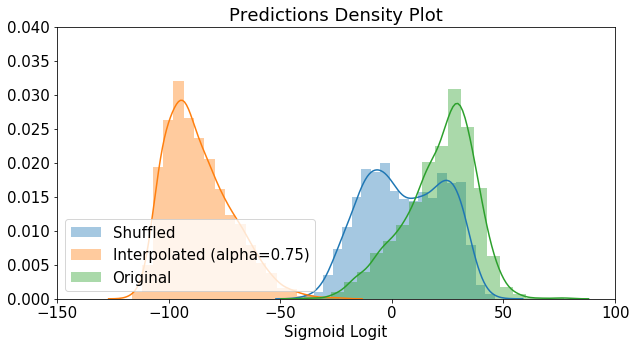

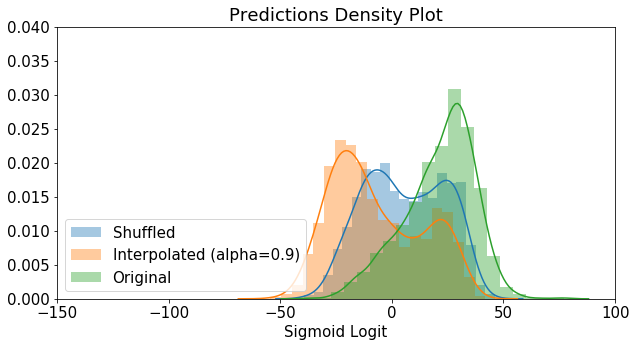

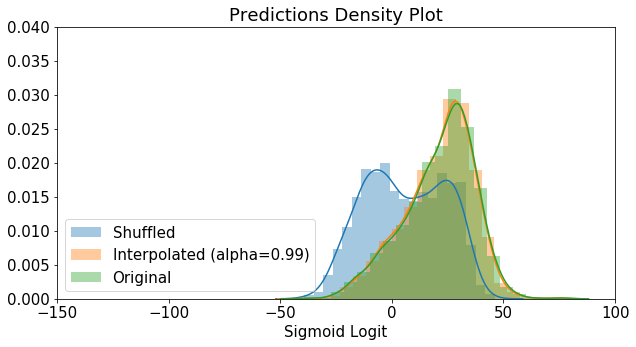

In [11]:
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

for i in range(len(alphas)):
    plt.figure(figsize=(10,5))
    handles = []
    handles.append(sns.distplot(shuffled_preds, bins=20))
    handles.append(sns.distplot(interp_preds[i], bins=20))
    handles.append(sns.distplot(orig_preds, bins=20))
    plt.title("Predictions Density Plot")
    plt.legend(handles, labels=["Shuffled", "Interpolated (alpha="+str(alphas[i])+")", "Original"], loc="lower left")
    plt.xlabel("Sigmoid Logit")
    plt.xlim(-150,100)
    plt.ylim(0,0.04)
    plt.show()